In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


tensorflow 1점대 버전에서 지원하는 코드 존재함.
로컬에서 진행하려면 python3.6이하 버전에서 학습 가능하다.

아래 코드 진행후 런타임 다시시작

In [ ]:
# !pip install --ignore-installed --upgrade tensorflow==1.6.0

In [ ]:
import re
import nltk
import operator
import numpy as np
import pandas as pd
from math import log
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# amazon = pd.read_csv('/content/drive/My Drive/amazon_reviews.csv')
binary_airline = pd.read_csv('/content/drive/My Drive/binary_air_review.csv')
# binary_hotel = pd.read_csv('/content/drive/My Drive/hotel-reviews.csv')
# clothing = pd.read_csv('/content/drive/My Drive/clothing.csv')
# movie = pd.read_csv('/content/drive/My Drive/train.csv')
# steam = pd.read_csv('/content/drive/My Drive/steam.csv')
# yelp = pd.read_csv('/content/drive/My Drive/yelp.csv')

In [ ]:
# sorting = amazon.sort_values(['label'])                     ## contents
sorting = binary_airline.sort_values(['rating'])            ## comment
# sorting = binary_hotel.sort_values(['Is_Response'])         ## Description
# sorting = clothing.sort_values(['Recommended IND'])         ## Review Text
# sorting = movie.sort_values(['sentiment'])                  ## text
# sorting = steam.sort_values(['user_suggestion'])            ## user_review
# sorting = yelp.sort_values(['rating'])                      ## review

In [ ]:
sorting

,Unnamed: 0,comment,rating
0,0,Good customer service thejith. Dealing with cu...,0
24897,24897,I have used WallyPark several times with very ...,0
24898,24898,Very happy and pleased with experience at Wall...,0
24899,24899,Will not park anywhere else! Quality of servic...,0
24900,24900,"Quality and service has fallen off, plus ended...",0
...,...,...,...
49776,103536,This was our first and last experience with Wa...,1
49777,103537,Had some really bad experiences: 1) Was LIED t...,1
49778,103538,Excellent service and excellent products! When...,1
49798,103558,Booked 3 rooms and was sent a misleading email...,1


In [ ]:
## 본문부분 열 이름과 점수부분 열 이름 입력

contents_name = "comment"
label_name = "rating"

In [ ]:
def data_loading(sorting, contents_name, label_name):

  review_ = sorting.reset_index()
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(review_[label_name])
  target_encoded = encoder.transform(review_[label_name])

  contents = list(np.array(review_[contents_name].tolist()))
  label = list(target_encoded)
  cnts_N = contents[:2000]+contents[-2000:]   ## X_train
  label_N = label[:2000]+label[-2000:]        ## y_train

  ## train data를 제외한 test data
  test_dict = {'document':contents[2000:-2000],"label":label[2000:-2000]}
  test_df = pd.DataFrame(test_dict)

  np.random.seed(0)

  df_shuffled=test_df.iloc[np.random.permutation(test_df.index)].reset_index(drop=True)
  df_shuffled

  tdata = df_shuffled['document']
  tlabel = df_shuffled['label']

  return cnts_N, label_N, tdata, tlabel

In [ ]:
## train test split과 같이 진행

train_X, train_Y, test_X, test_Y = data_loading(sorting, contents_name, label_name)

In [ ]:
def preprocessing(data):

    from nltk import FreqDist
    from nltk.stem.snowball import SnowballStemmer
    snowball = SnowballStemmer('english')

    normalized_text = []  ## 괄호 제거 및 문자이외의 데이터 제거
    for scr in data:
        scr = re.sub('\(', ' ', scr)
        scr = re.sub('\)', ' ', scr)
        scr = re.sub('[^ a-zA-Zㄱ-힗]', '', scr)
        normalized_text.append(scr.lower())

    result = [word_tokenize(sentence) for sentence in normalized_text]  ## 토큰화

    ## 단어 빈도 수 계산( 10번이상 등장하지 않는 단어 stopword에 포함 )
    vocab = list(set(w for i in result for w in i))
    vocab.sort()

    check_freq = []
    for line in result:
        for wd in line:
            check_freq.append(wd)

    fdist = FreqDist(check_freq)

    low_freq = []
    for i in vocab:
        if fdist[i] < 10:
            low_freq.append(i)

    stop_words = set(stopwords.words('english'))
    stop_words = list(stop_words)
    for i in low_freq:
        stop_words.append(i)

    ## stopwords 제거 및 stemming
    except_stopword = []
    for st in result:
        temp = []
        for tk in st:
            if tk not in stop_words:
                temp.append(snowball.stem(tk))
        except_stopword.append(temp)
    
    return except_stopword

In [ ]:
train_tokens = preprocessing(train_X)

리뷰의 최대 길이 : 381
리뷰의 평균 길이 : 56.27275


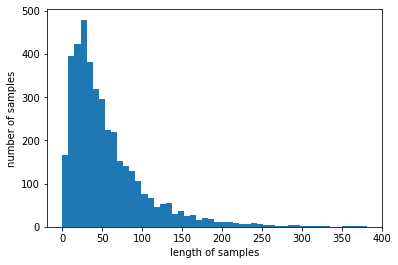

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_tokens))
print('리뷰의 평균 길이 :',sum(map(len, train_tokens))/len(train_tokens))
plt.hist([len(s) for s in train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
vocab = list(set(w for i in train_tokens for w in i ))
vocab.sort()

In [ ]:
print('단어의 갯수는 총 %d개 이다'%(len(vocab)))

2451

In [ ]:
def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

train_corp = corpus(train_tokens)

2.1.5 버전 이하의 keras 설치

In [ ]:
!pip install keras==2.1.5

In [ ]:
import keras
from keras_preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tokens)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2451
등장 빈도가 1번 이하인 희귀 단어의 수: 0
단어 집합에서 희귀 단어의 비율: 0.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.0


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2453


Word2Vec embedding matrix 생성

In [ ]:
from gensim.models import Word2Vec
import gensim

size_embedding = 200 #Dimensionality of the feature vectors
windows = 3 #Maximum distance between the current and predicted word within a sentence
min_count = 1 #Ignores words with total frequency lower than this
maxlen = 70 #Length decided for the text (adjusted by padding and truncating)

w2v_model = gensim.models.Word2Vec(sentences = train_tokens, 
                                   size = size_embedding, 
                                   window = windows, 
                                   min_count = min_count)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(train_tokens)
text_train_tok = tokenizer.texts_to_sequences(train_tokens)
word_index = tokenizer.word_index
print('Sive of vocabulary: ', len(word_index))

text_train_tok_pad = sequence.pad_sequences(text_train_tok, maxlen=maxlen, value = len(word_index))

Sive of vocabulary:  2452


In [ ]:
embedding_matrix = np.zeros((vocab_size, size_embedding)) 

for index, word in enumerate(word_index):
    if word in w2v_model:
        embedding_vector = w2v_model[word] 
        embedding_matrix[index] = embedding_vector
    else:
        print("word2vec에 없는 단어입니다.")
        break

word2vec에 없는 단어입니다.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
#키워드를 역추적하기 위한 사전 생성 
word_rev_dict = dict([(v,k) for k, v in word_index.items()])

In [ ]:
num_class = 2

train_y = keras.utils.to_categorical(train_Y, num_class)

In [ ]:
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras.optimizers import *
from keras.callbacks import *
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
import keras.backend as K
import tensorflow as tf

CNN 모델 학습

In [ ]:
def cnn_model(embedding_vectors):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix], 
                        input_length=maxlen, 
                        trainable=False))
    model.add(Conv1D(32, 1, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    return model

In [ ]:
model = cnn_model(embedding_vectors = embedding_matrix)

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 200)           490600    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 70, 32)            6432      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 22        
Total params: 497,384
Trainable params: 6,784
Non-trainable params: 490,600
_________________________________________________________________


In [ ]:
hist = model.fit(x=text_train_tok_pad,y=train_y, batch_size=16, epochs=20, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 2s 503us/step - loss: 0.6916 - acc: 0.5159 - val_loss: 0.6910 - val_acc: 0.5062
Epoch 2/20
3200/3200 [==============================] - 1s 374us/step - loss: 0.6888 - acc: 0.5481 - val_loss: 0.6855 - val_acc: 0.5813
Epoch 3/20
3200/3200 [==============================] - 1s 377us/step - loss: 0.6866 - acc: 0.5459 - val_loss: 0.6854 - val_acc: 0.5563
Epoch 4/20
3200/3200 [==============================] - 1s 387us/step - loss: 0.6836 - acc: 0.5563 - val_loss: 0.6806 - val_acc: 0.5700
Epoch 5/20
3200/3200 [==============================] - 1s 377us/step - loss: 0.6791 - acc: 0.5694 - val_loss: 0.6889 - val_acc: 0.5487
Epoch 6/20
3200/3200 [==============================] - 1s 381us/step - loss: 0.6764 - acc: 0.5847 - val_loss: 0.6767 - val_acc: 0.5813
Epoch 7/20
3200/3200 [==============================] - 1s 375us/step - loss: 0.6741 - acc: 0.5850 - val_loss: 0.6788 - val_acc: 0.5613
E

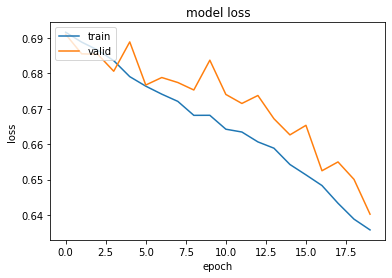

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
## gradCAM에 적용 시키기 위해 test set 토큰화 밒 padding 진행

parsed_text = preprocessing(test_X[:1000])
test_corp = corpus(parsed_text)
text_test_tok = tokenizer.texts_to_sequences(parsed_text)
text_test_tok_pad = sequence.pad_sequences(text_test_tok, maxlen=maxlen, value = len(word_index))

## label class 크기만큼 one-hot 으로 변환

test_y = keras.utils.to_categorical(test_Y[:1000], num_class)

In [ ]:
text_test_tok_pad.shape, test_y.shape

((1000, 70), (1000, 2))

Grad-CAM 진행

In [ ]:
def grad_cam_conv1D(model, layer_nm, x, sample_weight=1,  keras_phase=0):
    import keras.backend as K
    import numpy as np
    
    #레이어 이름에 해당되는 레이어 정보를 가져옴 
    layers_wt = model.get_layer(layer_nm).weights
    layers = model.get_layer(layer_nm)
    layers_weights = model.get_layer(layer_nm).get_weights()
    
    #긍정 클래스를 설명할 수 있게 컨볼루션 필터 가중치의 gradient를 구함
    grads = K.gradients(model.output[:,0], layers_wt)[0]
    
    #필터별로 가중치를 구함 
    pooled_grads = K.mean(grads, axis=(0,1))
    get_pooled_grads = K.function([model.input,model.sample_weights[0], K.learning_phase()], 
                          [pooled_grads, layers.output[0]])
    
    pooled_grads_value, conv_layer_output_value = get_pooled_grads([[x,], [sample_weight,], keras_phase])
    
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    # gradCAM = np.maximum(heatmap,0)
    gradCAM = heatmap.copy()
    gradCAM /= np.max(abs(gradCAM))

    return ((gradCAM, heatmap, pooled_grads_value))

Gradient를 계산할 convolution layer 설정

In [ ]:
layer_nm = 'conv1d_5'

layers_wt = model.get_layer(layer_nm).weights
layers = model.get_layer(layer_nm)
layers_weights = model.get_layer(layer_nm).get_weights()

한 문장씩 예시

In [ ]:
idx = 5

In [ ]:
prob = model.predict(text_test_tok_pad)

In [ ]:
prob[idx], test_corp[idx], test_y[idx]

(array([0.5053932, 0.4946068], dtype=float32),
 'ive alreadi love ill review hotel didnt like well one didnt amaz chocol go first place way chocol food drink dessert store insid restaur perfect take home littl someth dinner n unfortun full dessert',
 array([0., 1.]))

In [ ]:
gradCAM, hm, graded = grad_cam_conv1D(model, 'conv1d_5', x=text_test_tok_pad[idx])

In [ ]:
x_ = [word_rev_dict[i] for i in text_test_tok_pad[idx]]

In [ ]:
len(gradCAM), len(x_)

(70, 70)

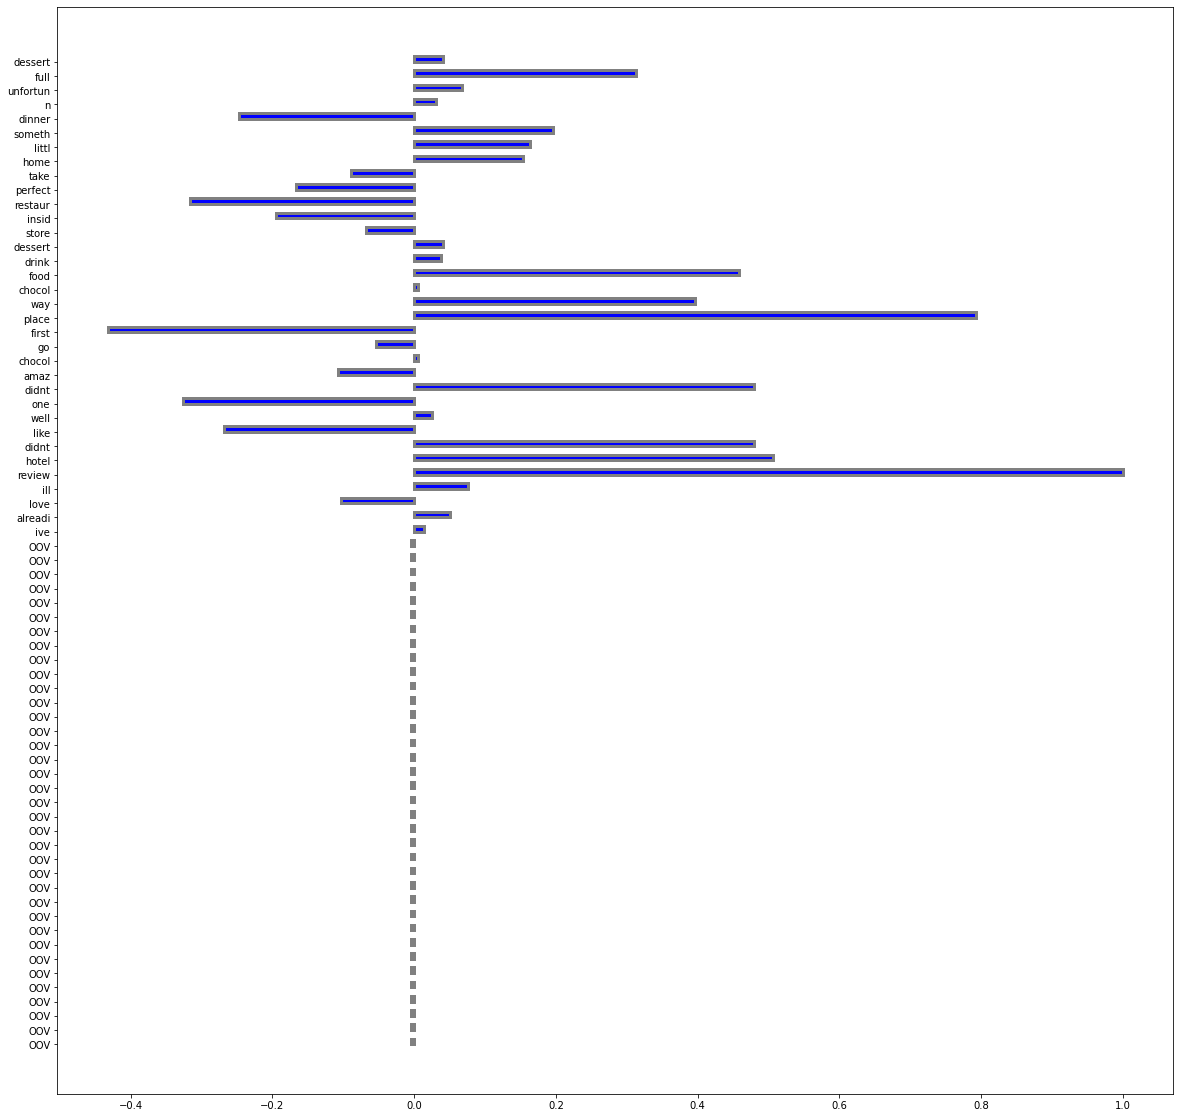

In [ ]:
plt.figure(figsize = (20,20))
plt.barh(np.arange(len(x_)), gradCAM, height=0.4, align='edge', tick_label = x_, color="blue",
        edgecolor="gray", linewidth=3, log=False)
plt.show()

In [ ]:
## 예측값이 0 또는 1과 가까운 문장들만 사전 생성에 이용

def make_dict(idx, text_test_tok_pad):
  
  score_dict = {}
  prediction = model.predict(text_test_tok_pad)
  list_ = [word_rev_dict[i] for i in text_test_tok_pad[idx]]
  if abs(0.5-max(prediction[idx])) > 0.2:
    gradCAM, hm, graded = grad_cam_conv1D(model, 'conv1d_1', x=text_test_tok_pad[idx])
  
    score_dict = {k:v for k,v in zip(list_, gradCAM)}
    tmp = sorted(score_dict.items(), key = lambda item: abs(item[1]), reverse=True)
    tdf = pd.DataFrame(tmp).set_index([0])

  return tdf

In [ ]:
## gradCAM를 많이 사용하면 런타임 에러 일어나서 중간에 끊을 수 있게 cut-off 설정
## 각 문장 별로 단어별 점수를 dataframe 형태로 저장

def make_dataframe(text_test_tok_pad, cut_off):

  update_df = pd.DataFrame(index=range(0,1), columns=['score'])
  i=0
  for k in range(len(text_test_tok_pad)):
    try :
      df_ = make_dict(k, text_test_tok_pad)
      i+=1
    except UnboundLocalError:
      print(k,'번째는 조건 성립 X')

    try :
      update_df = pd.merge(update_df, df_, how='outer', left_index=True, right_index = True)
      if k%10 == 0:
        print(k,'/',len(text_test_tok_pad),'진행중...')
 
    except (TypeError, NameError):
      if k%10 == 0:
        print(k,'/',len(text_test_tok_pad),'진행중...')

    if k == cut_off:
      break
  print(i,'개 이용')

  return update_df

update_df = make_dataframe(text_test_tok_pad, 350)

In [ ]:
## NaN 값은 0으로 채운다

zero_df = update_df.fillna(0)

In [ ]:
## 중간 저장

# zero_df.to_csv("/content/drive/My Drive/test2_dataframe.csv", mode='w')

In [ ]:
## 평균 값으로 하려면 mean, 최대값으로 하려면 max 로 모든 열을 1열로 변경

# final_df = pd.DataFrame(zero_df.mean(axis=1))
final_df = pd.DataFrame(zero_df.max(axis=1))

In [ ]:
final_df

In [ ]:
## Dataframe -> dictionary

final_df.to_dict('dict')[0]

In [ ]:
## 빈도수 기준으로 긍정단어와 부정단어를 선정

def counter_pos_neg(pos_corp, neg_corp):
  pos_token = preprocessing(pos_corp)
  neg_token = preprocessing(neg_corp)

  pos_words = []
  neg_words = []

  for item in pos_token:
          pos_words.extend(item)

  for item in neg_token:
          neg_words.extend(item)

  from collections import Counter

  pos_result = Counter(pos_words)
  neg_result = Counter(neg_words)

  return pos_result, neg_result

In [ ]:
pos_result, neg_result = counter_pos_neg(train_X[:2000], train_X[-2000:])

In [ ]:
## 사전에서 OOV 단어 제거

final_df = final_df.drop(['OOV',0])

In [ ]:
## 사전 생성

score_dict = final_df.to_dict('dict')[0]

In [ ]:
## 선정된 긍정/부정 단어를 이용해서 부호를 할당

def assign_symbol(score_dict):
  lexicon = {}

  for k, v in score_dict.items():
    if (k not in pos_result) and (k not in neg_result):
      None
    else :
      if pos_result[k] >= neg_result[k]:
        lexicon[k] = -v
      else :
        lexicon[k] = v
  
  return lexicon

lexicon = assign_symbol(score_dict)

In [ ]:
lexicon 

In [ ]:
sorted(lexicon.items(), key=(lambda x:x[1]))

In [ ]:
sorted(lexicon.items(), key=(lambda x:x[1]), reverse=True)

In [ ]:
## 뒤에서 부터 1000개 validation data 생성

val_x = preprocessing(test_X[-1000:])
val_y = test_Y[-1000:]

In [ ]:
## 사전 정규화 진행

def dict_normalize(score_dict):
  key = list(score_dict.keys())
  value = np.array(list(score_dict.values()))
  value /= np.max(abs(value))
  normalize_dict = {k:v for k, v in zip(key, value)} 
  return normalize_dict

In [ ]:
## 기준점수가 0이 아닌경우가 있다...
## test_set labeling 과정 긍/부정 함수를 정규화 후 라벨링 진행

def semi_labeling(tkns, s_dict):
  test_label = []
  score = []
  normalize_dict = dict_normalize(s_dict)
  for tokens in tkns:
    p = 0
    n = 0
    for t in tokens:
      if t in normalize_dict:
        if normalize_dict[t]<0:
          p+=normalize_dict[t]
        elif normalize_dict[t]>0:
          n+=normalize_dict[t]
        else:
          None
       
    if p+n <= 0:
      test_label.append(0)
    elif p+n > 0:
      test_label.append(1)

    score.append(p+n)
  return test_label, score

test_label, score = semi_labeling(val_x, lexicon)

In [ ]:
def cal_acc(y, pred):
  accuracy = np.mean(np.equal(y,pred))

  return accuracy

acc = cal_acc(val_y,test_label)
acc

In [ ]:
accuracy = []
t_acc = []

accuracy.append(acc)
for i in tqdm(range(2,35)):
  print("\ntest data setting......")
  test_ = test_X[1000*i:1000*(i+1)]
  label_ = test_Y[1000*i:1000*(i+1)]
  test_tokens = preprocessing(test_)
  text_tok = tokenizer.texts_to_sequences(test_tokens)
  X_test = sequence.pad_sequences(text_tok, maxlen=maxlen, value = len(word_index))
  y_test = np.array([label_])

  prediction, _ = semi_labeling(X_test, lexicon)
  acc_ = cal_acc(label_,prediction)
  t_acc.append(acc_)

  update_df_ = make_dataframe(X_test, 100)
  zero_df = update_df_.fillna(0)

  update_df = pd.merge(update_df, zero_df, how='outer', left_index=True, right_index = True)

  final_df = pd.DataFrame(update_df.mean(axis=1))
  score_dict = final_df.to_dict('dict')[0]
  lexicon = assign_symbol(score_dict)

  test_label, score = semi_labeling(val_x, lexicon)
  
  acc = cal_acc(val_y,test_label)
  accuracy.append(acc)
  print("정확도 : ",acc)

In [ ]:
plt.plot(accuracy)
plt.plot(t_acc)
plt.legend(['v_acc', 't_acc'])
plt.ylim(0.690, 0.80)

plt.show()